In [3]:
from math import cos, sin
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np

#### Utils

In [4]:
from typing import Union

DEFAULT_EPSILON = 1e-6
FUNCTION_INPUT_TYPE = Union[np.ndarray, float]


def is_elementwise_close(
        previous: FUNCTION_INPUT_TYPE,
        future: FUNCTION_INPUT_TYPE,
        epsilon: float = DEFAULT_EPSILON
):
    if isinstance(previous, float) and isinstance(future, float):
        return abs(previous - future) < epsilon
    else:
        return np.alltrue(np.abs(previous - future) < epsilon)

#### Learning rate scheduler's

In [5]:
class LearningRateScheduler:
    def __init__(self, lr: float):
        self.lr = lr

    def step(self, *args, **kwargs) -> float:
        raise NotImplementedError("`step` method must be implemented by subclasses")


class ConstantScheduler(LearningRateScheduler):
    def step(self) -> float:
        return self.lr


class ExponentialScheduler(LearningRateScheduler):
    def __init__(self, lr: float, gamma: float, every: int):
        super().__init__(lr)
        self.gamma = gamma
        self.every = every
        self.steps = 0

    def step(self) -> float:
        self.steps += 1
        if self.steps % self.every == 0:
            self.lr *= self.gamma
        return self.lr

In [6]:
class GradientDescentOptimizer:
    def __init__(
            self,
            function: Callable[[FUNCTION_INPUT_TYPE], float],
            derivative: Callable[[FUNCTION_INPUT_TYPE], np.ndarray],
    ):
        self.function = function
        self.derivative = derivative

    def optimize(
            self,
            initial: np.ndarray,
            iterations: int,
            scheduler: LearningRateScheduler,
            epsilon: float = DEFAULT_EPSILON
    ):
        """
        :return: (minimum, trace, steps)
        """
        trace = []
        minimum_x = initial
        iteration = 0
        for iteration in range(iterations):
            trace.append((minimum_x, self.function(minimum_x)))
            next_minimum_x = minimum_x - self.derivative(minimum_x) * scheduler.step()

            if is_elementwise_close(minimum_x, next_minimum_x, epsilon):
                break

            minimum_x = next_minimum_x

        return minimum_x, trace, iteration + 1

#### Visualizing utils

In [7]:
from typing import List
from typing import Tuple
from matplotlib import animation


def animate(
        x_range: np.ndarray,
        f: Callable[[FUNCTION_INPUT_TYPE], float],
        trace: List[Tuple[FUNCTION_INPUT_TYPE, float]],
        output: str,
        fps=10
):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_range, f(x_range))

    (x0, y0) = trace[0]
    xs, ys = zip(*trace[1:])

    line, = ax.plot(x0, y0, 'red')  # initial data
    dot = ax.scatter(x0, y0, c='g', marker="o")  # initial point

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    # Function updates data for plot animation using animation.FuncAnimation() below
    # The variable that is passed to this function from FuncAnimation is frames=itersteps-1
    # This acquires the data at every iteration step
    def update(iteration):
        ax.relim()  # resizing plot area
        ax.autoscale_view(True, True, True)  # resizing plot area
        dot.set_offsets([xs[iteration], ys[iteration]])
        ax.set_title(r'Gradient Descent, iteration: ' + str(iteration))
        return line, ax

    # Animation function after all the variables at each iteration have been calculated
    # Calls the function update and passes in the number of frames=itersteps-1 to get all the data at each iteration
    ani = animation.FuncAnimation(fig, update, frames=len(trace) - 1, interval=200, blit=False, repeat_delay=200)

    # Saves animations as .mp4
    filename = f'{output}.mp4'
    # filename = 'quadratic_example_alpha_' + str(a) + '.mp4'
    ani.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])

In [8]:
def plot1d_descent(minimum_x, f, trace, ax):
    colors = ['r', 'g', 'b', 'orange']
    xs_range = np.linspace(-4, 4, 500)
    f = np.vectorize(f)
    trace_len = len(trace) // 30 + 1
    x_trace, y_trace = zip(*trace[::trace_len])

    ax.plot(xs_range, f(xs_range))
    ax.plot(minimum_x, f(minimum_x), marker='o', c=colors[(i + 1) % len(colors)], markersize=10)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.scatter(x_trace, y_trace, c=colors[i % len(colors)])

#### 1. Constant learning rate

Function for minimization:
<br>
$f(x)  = cos(x) * x$
$f'(x) = cos(x) - sin(x) * x$

In [9]:
f = lambda x: cos(x) * x
derivative = lambda x: cos(x) - sin(x) * x

iterations = 50_000
initial = 0.8

lrs = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

data = []

for lr in lrs:
    scheduler = ConstantScheduler(lr)
    optimizer = GradientDescentOptimizer(f, derivative)
    result = optimizer.optimize(initial, iterations, scheduler)
    data.append((*result, lr))

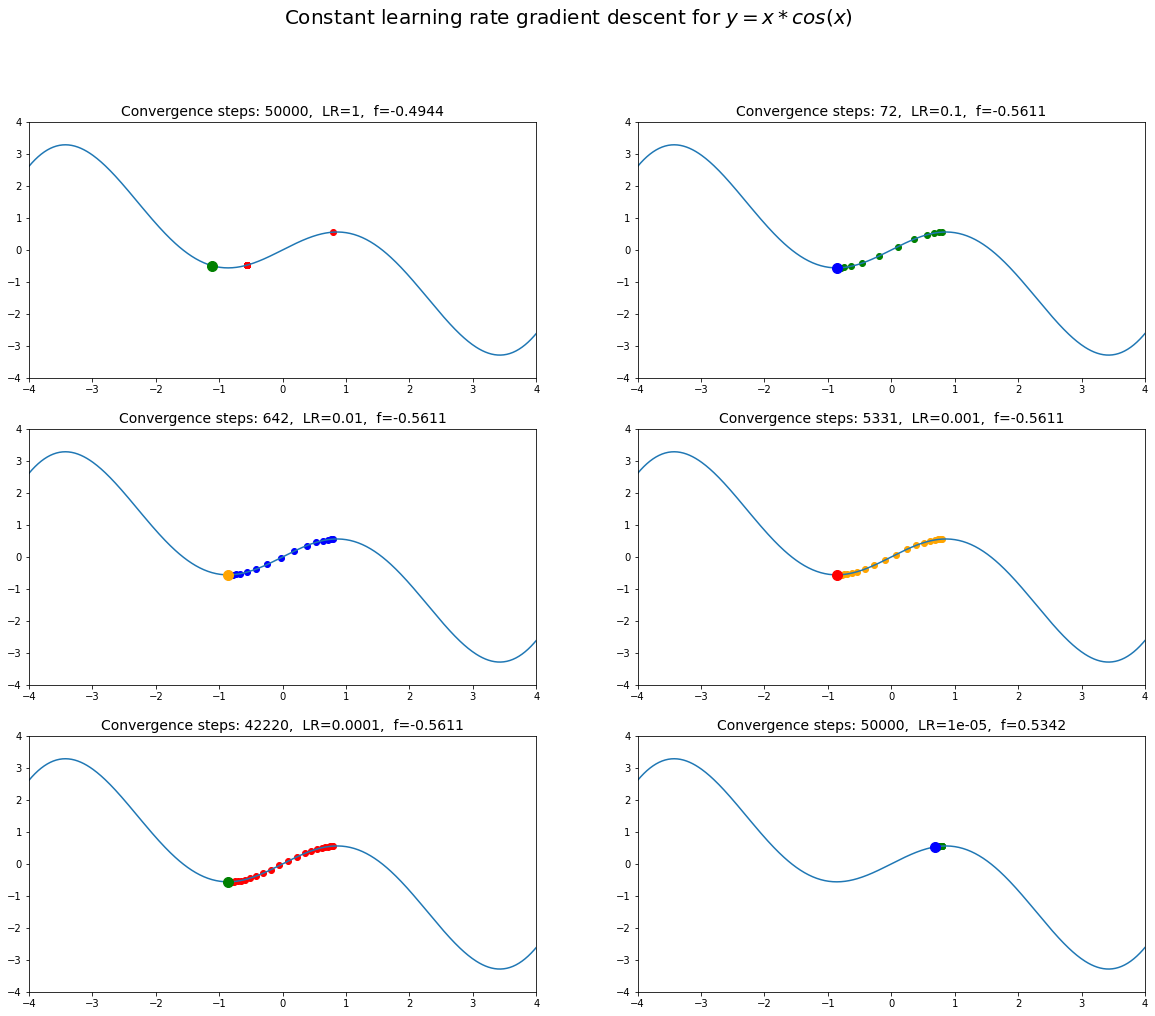

In [10]:
cols = 2
rows = len(data) // cols

figure, axs = plt.subplots(rows, cols, figsize=(20, 16))
figure.suptitle("Constant learning rate gradient descent for $y = x * cos(x)$", fontsize=20)

for i, (minimum_x, trace, made_steps, lr) in enumerate(data):
    col = i % 2
    row = i // 2
    ax = axs[row][col]

    plot1d_descent(minimum_x, f, trace, ax)
    ax.set_title(f"Convergence steps: {made_steps},  LR={lr},  f={f(minimum_x):.4}", fontsize=14)

plt.show()

#### 2. Exponential learning rate scheduling

In [11]:
f = lambda x: cos(x) * x
derivative = lambda x: cos(x) - sin(x) * x

iterations = 50_000
initial = 0.8

LR = 1.5
gammas = [0.99, 0.9, 0.5, 0.1]

data = []

for gamma in gammas:
    scheduler = ExponentialScheduler(LR, gamma=gamma, every=10)
    optimizer = GradientDescentOptimizer(f, derivative)
    result = optimizer.optimize(initial, iterations, scheduler)
    data.append((*result, gamma, scheduler.lr))

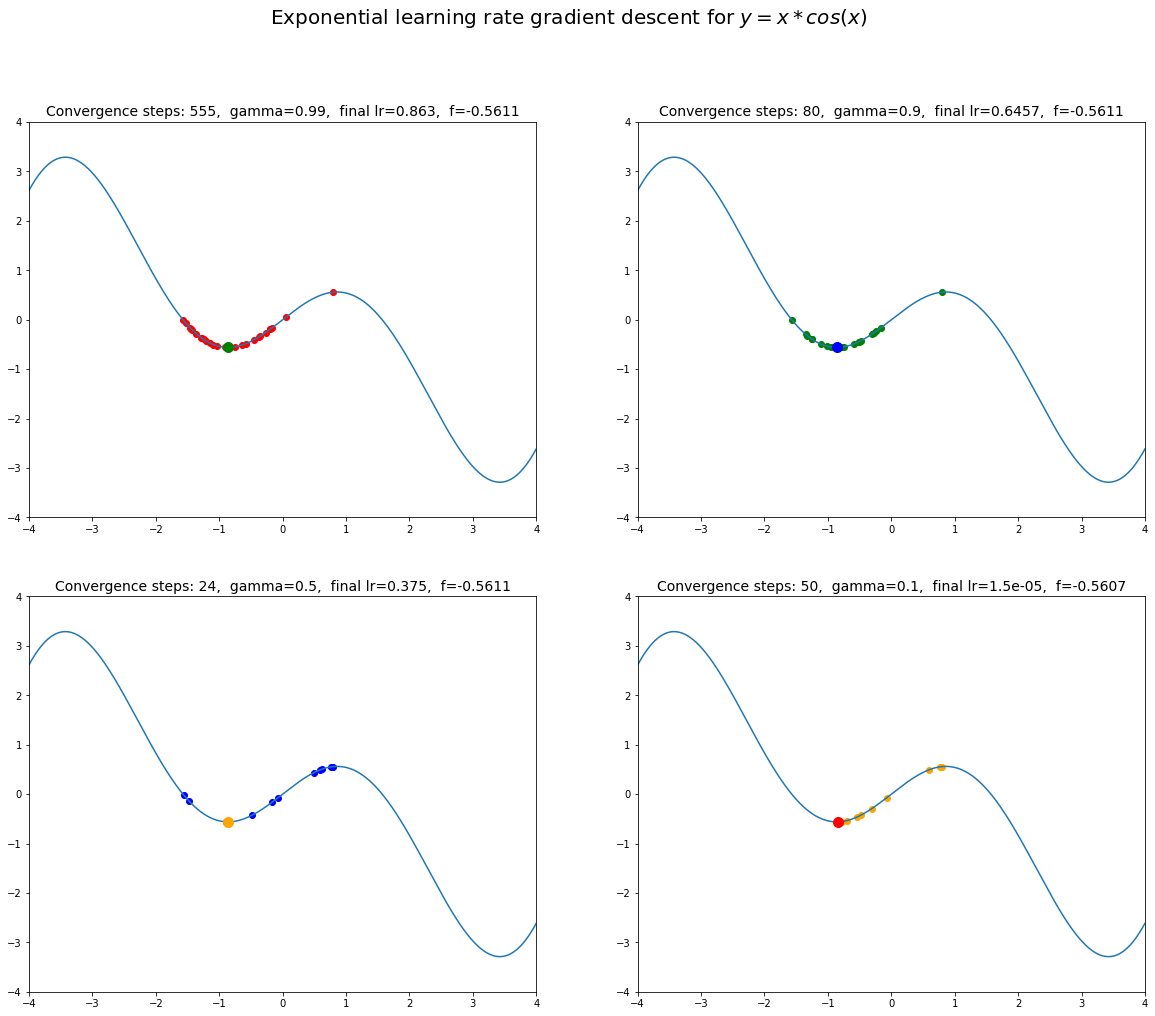

In [12]:
cols = 2
rows = len(data) // cols

figure, axs = plt.subplots(rows, cols, figsize=(20, 16))
figure.suptitle("Exponential learning rate gradient descent for $y = x * cos(x)$", fontsize=20)

for i, (minimum_x, trace, made_steps, gamma, lr) in enumerate(data):
    col = i % 2
    row = i // 2
    ax = axs[row][col]

    plot1d_descent(minimum_x, f, trace, ax)
    ax.set_title(f"Convergence steps: {made_steps},  gamma={gamma},  final lr={lr:.4},  f={f(minimum_x):.4}",
                 fontsize=14)

plt.show()

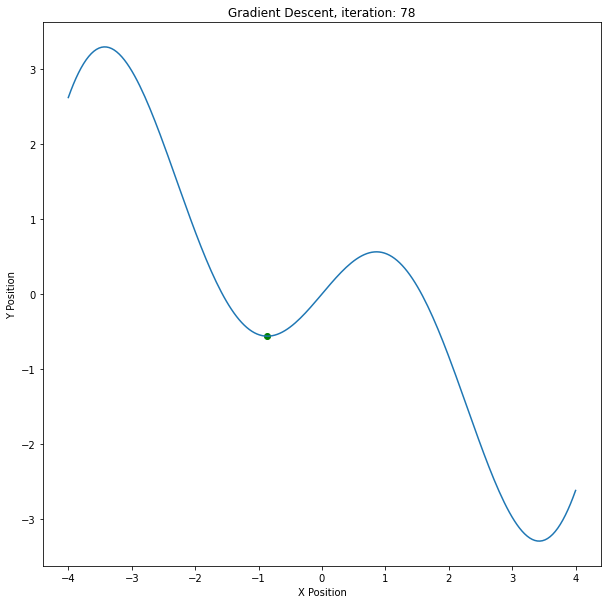

In [17]:
x_range = np.linspace(-4, 4, 200)
f = np.vectorize(lambda x: cos(x) * x)

trace = data[1][1]
video_suffix = 'gamma_0.9'

animate(x_range, f, trace, fps=10, output=f'video/{video_suffix}')

In [18]:
from video_utils import convert_mp4_to_jpgs, make_gif

convert_mp4_to_jpgs(f'video/{video_suffix}.mp4', f'frames/{video_suffix}')
make_gif(f'gifs/{video_suffix}.gif', f'frames/{video_suffix}')

#### Initial learning rate = 1.5

#### $gamma = 0.99$
<img src="gifs/gamma_0.99.gif" width="500">

#### $gamma = 0.9$
<img src="gifs/gamma_0.9.gif" width="500">

#### $gamma = 0.1$
<img src="gifs/gamma_0.1.gif" width="500">

### 3. Dichotomy (Fastest descent method)